## 1. Import bibliotek

In [19]:
# Ładuje rozszerzenie autoreload, które pozwala na automatyczne przeładowywanie modułów
%load_ext autoreload

# Ustawia tryb autoreload na 2 - wszystkie importowane moduły będą automatycznie przeładowywane przy każdej zmianie
%autoreload 2

from sklearn.linear_model import PoissonRegressor

from src.data.datareader import CleanedDataReader
from src.data.plots import freq_over_attribute_plot
from src.data.utils import create_group_id, drop_duplicates, dropna, prepare_target_and_weights
from src.features.sampling import split_data_by_group_and_stratify
from src.features.transformers import create_feature_pipeline, create_simple_feature_pipeline
from src.models.modeling import (
    train_and_evaluate_model,
    tune_glm_with_feature_pipeline,
    apply_best_params_and_train_model,
    tune_xgboost_model,
    save_model_with_pipeline,
    apply_best_params_and_train_xgboost_model
)
from src.models.scoring import print_summary

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 2. Wczytywanie danych

In [2]:
data_reader = CleanedDataReader(path='../../data/raw/claims_data.csv')
df = data_reader.get_enhanced_data(index_col=0)

Bad line:
['653', '1357.0', '1.0', '0.01', 'E', '7.0', '0.0', '41.0', '80.0', 'B12', 'Diesel', '6257.0', 'R93', '']
was converted to:
['653', '1357.0', '1.0', '0.01', 'E', '7.0', '0.0', '41.0', '80.0', 'B12', 'Diesel', '6257.0', 'R93']

Bad line:
['1435', '2967.0', '1.0', '0.64', 'B', '5.0', '0.0', '53.0', '50.0', 'B12', '', 'Regular', '68.0', 'R52']
was converted to:
['1435', '2967.0', '1.0', '0.64', 'B', '5.0', '0.0', '53.0', '50.0', 'B12', 'Regular', '68.0', 'R52']

Bad line:
['123123', '1070775.0', '0.0', '0.48', 'B', '8.0', '7.0', '42.0', '59.0', 'B2', 'Diesel', '72.0', 'R52', '']
was converted to:
['123123', '1070775.0', '0.0', '0.48', 'B', '8.0', '7.0', '42.0', '59.0', 'B2', 'Diesel', '72.0', 'R52']

Bad line:
['381011', '3043346.0', '0.0', '0.92', 'A', '4.0', '2.0', '60.0', '90.0', 'B12', '', 'Regular', '6.0', 'R72']
was converted to:
['381011', '3043346.0', '0.0', '0.92', 'A', '4.0', '2.0', '60.0', '90.0', 'B12', 'Regular', '6.0', 'R72']

Bad line:
['547534', '4138712.0', '1.0

## 3. Przygotowanie danych

Pierwsze, bardzo ogólne przetworzenie danych:
1. Usunięcie tych rekordów, które mają `NULL` w kolumnach `ClaimNb` lub `Exposure`,
2. Usunięcie duplikatów (jeżeli takie są) po kolumnie `IDPol`
3. Dodanie kolumny identyfikującej grupy polis z takimi samymi wartościami atrybutów - zadbamy o to, aby w momencie losowania zbiorów `train` i `test` polisy w ramach jednej grupy w całości znaleźli się w jednym ze zbiorów - ograniczymy w ten sposób ryzyko `Data Leakage`.
4. Ograniczenie wartości w kolumnach `ClaimNb` do maksymlanie 4 szkód oraz `Exposure` do maksymalnie 1.

In [3]:
df = dropna(df, subset=['ClaimNb', 'Exposure'])
df = drop_duplicates(df, subset=['IDpol'])
df = create_group_id(df)
df = df.assign(ClaimNb=lambda x: x.ClaimNb.clip(upper=4)).assign(Exposure=lambda x: x.Exposure.clip(upper=1))

### Przygotowanie Pipelines do przetwarzania danych

In [4]:
numerical_features = ['VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'Density']
categorical_features = [col for col in df.select_dtypes(exclude='number').columns.tolist() if col not in numerical_features]

print(f"All columns: {df.columns.tolist()}")
print(f"Numerical features: {numerical_features}")
print(f"Categorical features: {categorical_features}")

# Utworzenie pipeline'u z domyślnymi parametrami

pipeline_features = create_feature_pipeline(numerical_features, categorical_features)
pipeline_features.fit(df)


All columns: ['IDpol', 'ClaimNb', 'Exposure', 'Area', 'VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'VehBrand', 'VehGas', 'Density', 'Region', 'GroupID']
Numerical features: ['VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'Density']
Categorical features: ['Area', 'VehBrand', 'VehGas', 'Region']


Pipeline(steps=[('cap_veh_power',
                 CapTransformer(cap_value=13, column='VehPower',
                                else_behaviour='identity')),
                ('cap_veh_age',
                 CapTransformer(cap_value=21, column='VehAge',
                                else_behaviour='identity')),
                ('cap_driv_age',
                 CapTransformer(cap_value=90, column='DrivAge',
                                else_behaviour='identity')),
                ('cap_bonus_malus',
                 CapTransformer(cap_value=100, column='BonusMalus'...
                                                  ['VehAge']),
                                                 ('number',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['VehPower', 'VehAge',
                                                   'DrivAge', 'BonusMalus',
                                                   'Density']),
                                                 ('category',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Area', 'VehBrand', 'VehGas',
                                                   'Region'])],
                                   verbose_feature_names_out=False))])

### Atrybuty po zaaplikowaniu pipelinów

In [5]:
pipeline_features[-1].get_feature_names_out()

array(['DrivAge_0.0', 'DrivAge_1.0', 'DrivAge_2.0', 'DrivAge_3.0',
       'DrivAge_4.0', 'DrivAge_5.0', 'DrivAge_6.0', 'DrivAge_7.0',
       'DrivAge_8.0', 'DrivAge_9.0', 'DrivAge_10.0', 'DrivAge_11.0',
       'DrivAge_12.0', 'DrivAge_13.0', 'DrivAge_14.0', 'DrivAge_15.0',
       'DrivAge_16.0', 'DrivAge_17.0', 'DrivAge_18.0', 'DrivAge_19.0',
       'VehAge_0.0', 'VehAge_1.0', 'VehAge_2.0', 'VehAge_3.0',
       'VehAge_4.0', 'VehAge_5.0', 'VehAge_6.0', 'VehAge_7.0', 'VehPower',
       'VehAge', 'DrivAge', 'BonusMalus', 'Density', 'Area_A', 'Area_B',
       'Area_C', 'Area_D', 'Area_E', 'Area_F', 'VehBrand_B1',
       'VehBrand_B10', 'VehBrand_B11', 'VehBrand_B12', 'VehBrand_B13',
       'VehBrand_B14', 'VehBrand_B2', 'VehBrand_B3', 'VehBrand_B4',
       'VehBrand_B5', 'VehBrand_B6', 'VehGas_Diesel', 'VehGas_Regular',
       'Region_R11', 'Region_R21', 'Region_R22', 'Region_R23',
       'Region_R24', 'Region_R25', 'Region_R26', 'Region_R31',
       'Region_R41', 'Region_R42', 'Region_R4

### Prosty pipeline

In [6]:
simple_pipeline_features = create_simple_feature_pipeline(numerical_features, categorical_features)
simple_pipeline_features.fit(df)

Pipeline(steps=[('cap_veh_power',
                 CapTransformer(cap_value=13, column='VehPower',
                                else_behaviour='identity')),
                ('cap_veh_age',
                 CapTransformer(cap_value=21, column='VehAge',
                                else_behaviour='identity')),
                ('cap_driv_age',
                 CapTransformer(cap_value=90, column='DrivAge',
                                else_behaviour='identity')),
                ('cap_bonus_malus',
                 CapTransformer(cap_value=100, column='BonusMalus'...
                                   transformers=[('number',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['VehPower', 'VehAge',
                                                   'DrivAge', 'BonusMalus',
                                                   'Density']),
                                                 ('category',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Area', 'VehBrand', 'VehGas',
                                                   'Region'])],
                                   verbose_feature_names_out=False))])

In [7]:
simple_pipeline_features[-1].get_feature_names_out()

array(['VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'Density', 'Area_A',
       'Area_B', 'Area_C', 'Area_D', 'Area_E', 'Area_F', 'VehBrand_B1',
       'VehBrand_B10', 'VehBrand_B11', 'VehBrand_B12', 'VehBrand_B13',
       'VehBrand_B14', 'VehBrand_B2', 'VehBrand_B3', 'VehBrand_B4',
       'VehBrand_B5', 'VehBrand_B6', 'VehGas_Diesel', 'VehGas_Regular',
       'Region_R11', 'Region_R21', 'Region_R22', 'Region_R23',
       'Region_R24', 'Region_R25', 'Region_R26', 'Region_R31',
       'Region_R41', 'Region_R42', 'Region_R43', 'Region_R52',
       'Region_R53', 'Region_R54', 'Region_R72', 'Region_R73',
       'Region_R74', 'Region_R82', 'Region_R83', 'Region_R91',
       'Region_R93', 'Region_R94'], dtype=object)

## Podział zbioru na train i test
Podział jest dokonany tak aby:
1. Rekordy, które mają tę samą `GroupID` były w tym samym zbiorze (treningowy lub testowy) - `GroupShuffleSplit `
2. Zapewnić aby kolumna `ClaimNb` miała takie zbliżone proporcje w zbiorze train i test - `StratifiedShuffleSplit` 

In [8]:
train, test = split_data_by_group_and_stratify(df)

Train frequency: 10.049%
Test frequency: 10.109%
Train-test frequency difference: 0.060% (Relative difference: 0.594%)


# 4. Modelowanie

Rozkład Poissona jest naturalnym wyborem do modelowania liczby szkód ubezpieczeniowych, ponieważ dobrze opisuje rzadkie zdarzenia i przyjmuje tylko wartości nieujemne całkowite. Można oczywiście rozważan inne rozkłady (np. ujemny dwumianowy) testując rzeczywisty rozkład vs teoretyczny. Przyjąłem, że mają rozkład Poissona ważony. Dodatkowo każda obserwacja jest zważona ekspozycją.

W większości przypadków optymalizowałem Poisson Deviance i nastepnie analizowałem różnice do Poisson Deviance w DummyModel (model Poisson dla stałej - zważona ekspozycją średnia z liczby szkód).

### Pierwsze podejście do wytrenowania modelu - GLM z regularyzacją
1. Bias-Variance Tradeoff w GLM:
- Pomimo, iż GLM mają wypukłą funkcję straty i jedno globalne minimum, nadal mogą być zbyt złożone lub zbyt proste dla danych
    - Zbyt prosty (high bias) - gdy pomijamy ważne zmienne lub interakcje
    - Zbyt złożony (high variance) - gdy uwzględniamy zbyt wiele zmiennych lub nieistotne predyktory


2. Potencjalny overfitting w GLM (PoissonRegressor) może wynikać z następujących elementów:
- Mamy zbyt wiele zmiennych w stosunku do liczby obserwacji
- Zmienne są silnie skorelowane (multicollinearity)
- Model uwzględnia szum w danych treningowych


3. Metody przeciwdziałania overfittingowi w GLM:
- Regularyzacja (L1, L2)
- Selekcja zmiennych
- Cross-walidacja
- Analiza residuów i diagnostyka modelu


**W tym przypadku korzystam z regularyzacji L2 zaszytej w klasie PoissonRegressor. Analizując statystki modelu na zbiorze `train` i `test` oraz wykresach pokazujących prognozowaną `marginal frequency` wydaje się, że wytrenowany model dobrze uogólnia `pattern` z danych treningowych.**

W modelach GLM nie dodałem żadnych interakcji pomiędzy zmiennymi - traktuję go jako benchmark do bardziej złożonych modeli.

In [9]:
model_class = PoissonRegressor
params = {
    'alpha':0.001,
    'solver':'newton-cholesky'
}

model_glm_base, (summary_glm_base, X_train_pred_glm_base, X_test_pred_glm_base) = train_and_evaluate_model(train, test, pipeline_features, model_class, params)
save_model_with_pipeline(model_glm_base, '../../models/glm_based')
print_summary(summary_glm_base)

Model successfully saved to ../../models/glm_based.pkl.joblib
Poisson Deviance Dummy Train: 62.330
Poisson Deviance Dummy Test: 63.116
Poisson Deviance Train: 59.220
Poisson Deviance Test: 60.090
Improvement in Deviance Train: 4.991%
Improvement in Deviance Test: 4.794%
Frequency Train Actual: 10.049%
Frequency Train Model: 10.050%
Frequency Test Actual: 10.109%
Frequency Test Model: 10.019%


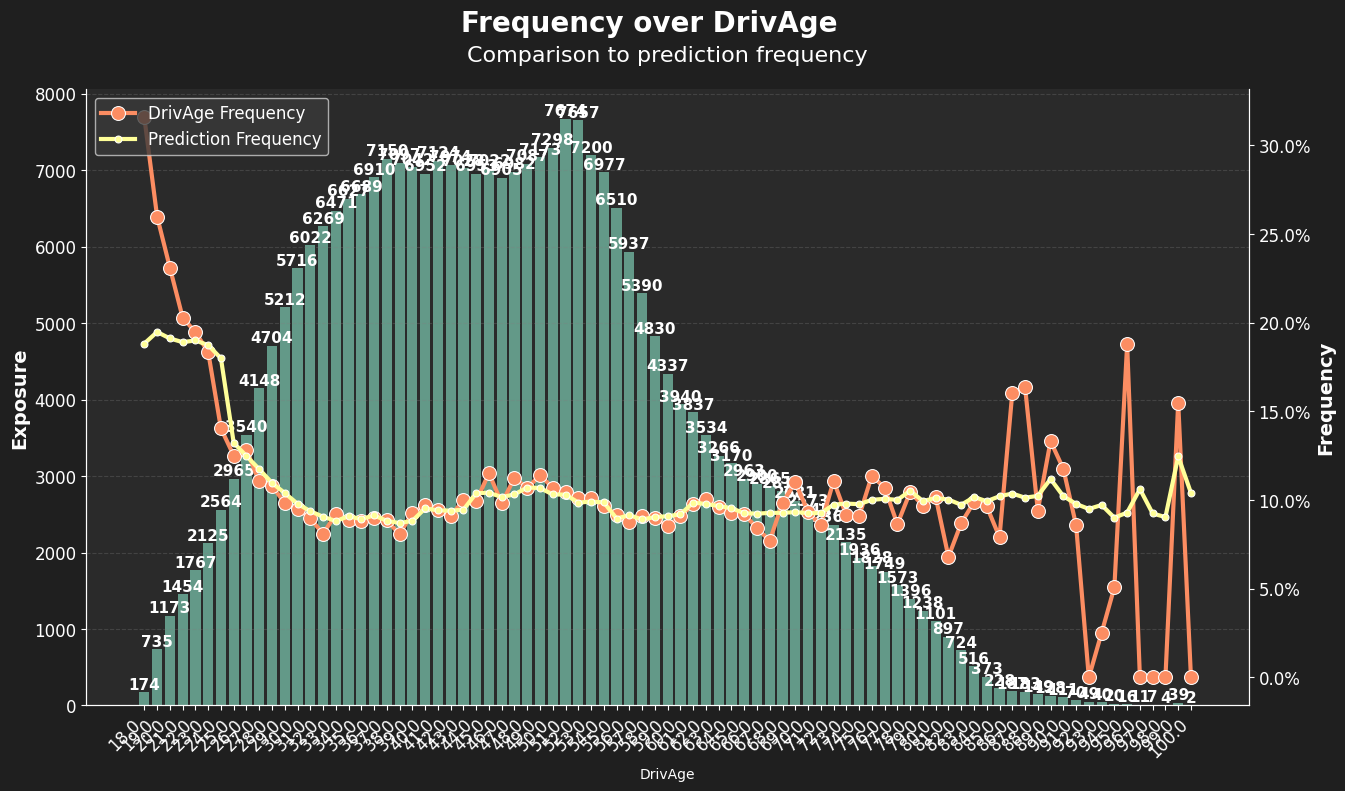

In [10]:
plot = freq_over_attribute_plot(X_train_pred_glm_base, attribute='DrivAge', compare_to='prediction')

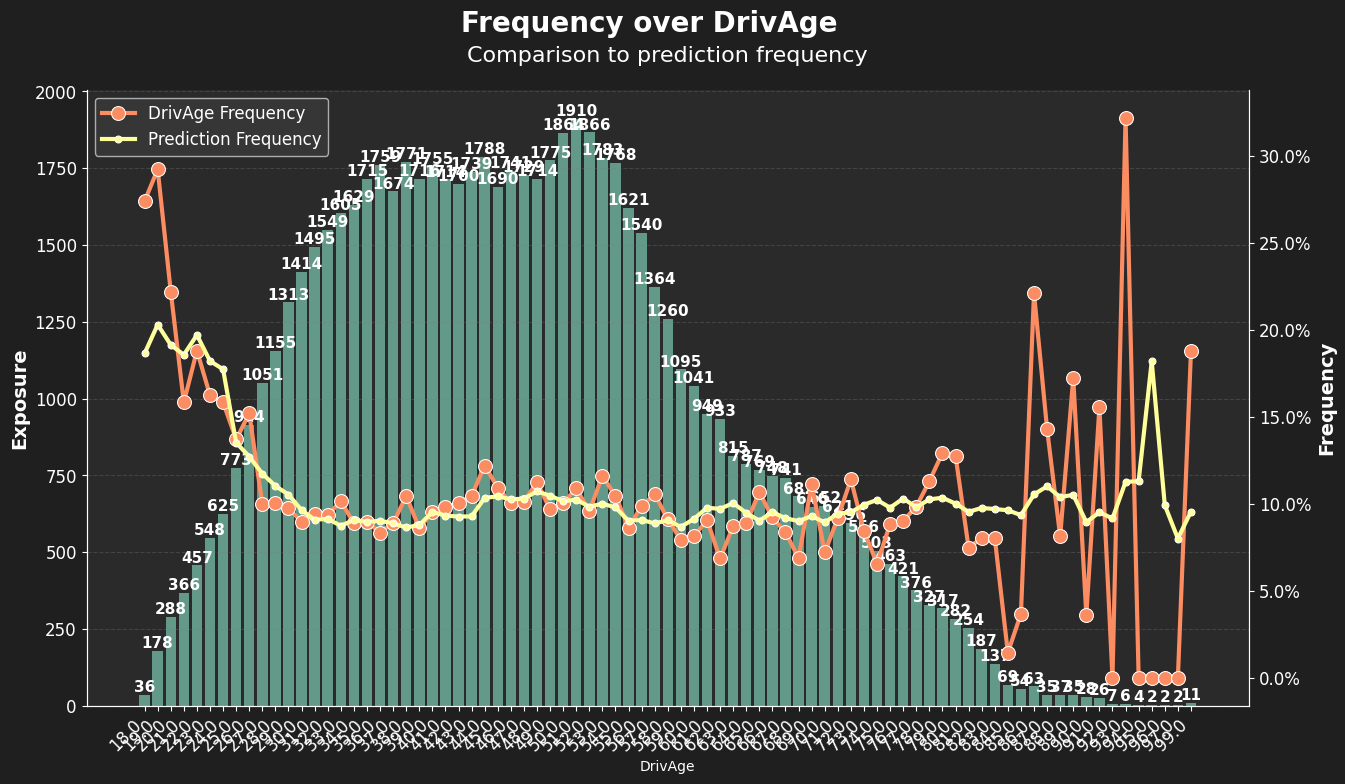

In [11]:
plot = freq_over_attribute_plot(X_test_pred_glm_base, attribute='DrivAge', compare_to='prediction')

# Model 2 - GLM z hipertuningiem preprocessu
Z wykorzystaniem `hyperopt` przeszukuję przestrzeń parametrów modelu PoissonRegressor (parametr regularyzacji L2 oraz maksymalną liczbę iteracji algorytmu) oraz przestrzeń konfiguracji pipelinu (jak ma podzielić zmienną `DrivAge` i `VehAge` oraz jak ma przyciąć wartości odstające w ramach kolumn `veh_power`, `veh_age`, `driv_age`, `bonus_malus`, `density`). Rezultatem poszukiwań jest najlepszy zestaw parametrów, który następnie wykorzystuję do trenowania finalnego modelu na całym zbiorze `train`.


In [12]:
N_trials = 10
y_train, weights_train, y_freq_train, y_test, weights_test, y_freq_test = prepare_target_and_weights(train, test)
best = tune_glm_with_feature_pipeline(train, test, numerical_features, categorical_features, n_trials=N_trials)

  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the numbe

 30%|███       | 3/10 [00:21<00:50,  7.23s/trial, best loss: 0.5947991424835368]

/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the numbe

 50%|█████     | 5/10 [00:35<00:35,  7.13s/trial, best loss: 0.5940168907279715]

/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the numbe

 60%|██████    | 6/10 [00:43<00:28,  7.16s/trial, best loss: 0.5940168907279715]

/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the numbe

 80%|████████  | 8/10 [00:57<00:14,  7.08s/trial, best loss: 0.5936231025639159]

/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the numbe

 90%|█████████ | 9/10 [01:04<00:07,  7.13s/trial, best loss: 0.5935694038663641]

/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the numbe

100%|██████████| 10/10 [01:11<00:00,  7.20s/trial, best loss: 0.5935694038663641]


In [13]:
model_glm_tuned, (summary_glm_tuned, X_train_pred_glm_tuned, X_test_pred_glm_tuned), pipeline_features = (
    apply_best_params_and_train_model(
        best, 
        train, 
        test, 
        numerical_features, 
        categorical_features, 
        path_to_save=f'../../models/glm_{N_trials}t_tuned_pipeline'
    )
)

/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


Model successfully saved to ../../models/glm_10t_tuned_pipeline.pkl.joblib
Poisson Deviance Dummy Train: 62.330
Poisson Deviance Dummy Test: 63.116
Poisson Deviance Train: 59.126
Poisson Deviance Test: 60.011
Improvement in Deviance Train: 5.142%
Improvement in Deviance Test: 4.919%
Frequency Train Actual: 10.049%
Frequency Train Model: 10.054%
Frequency Test Actual: 10.109%
Frequency Test Model: 10.021%


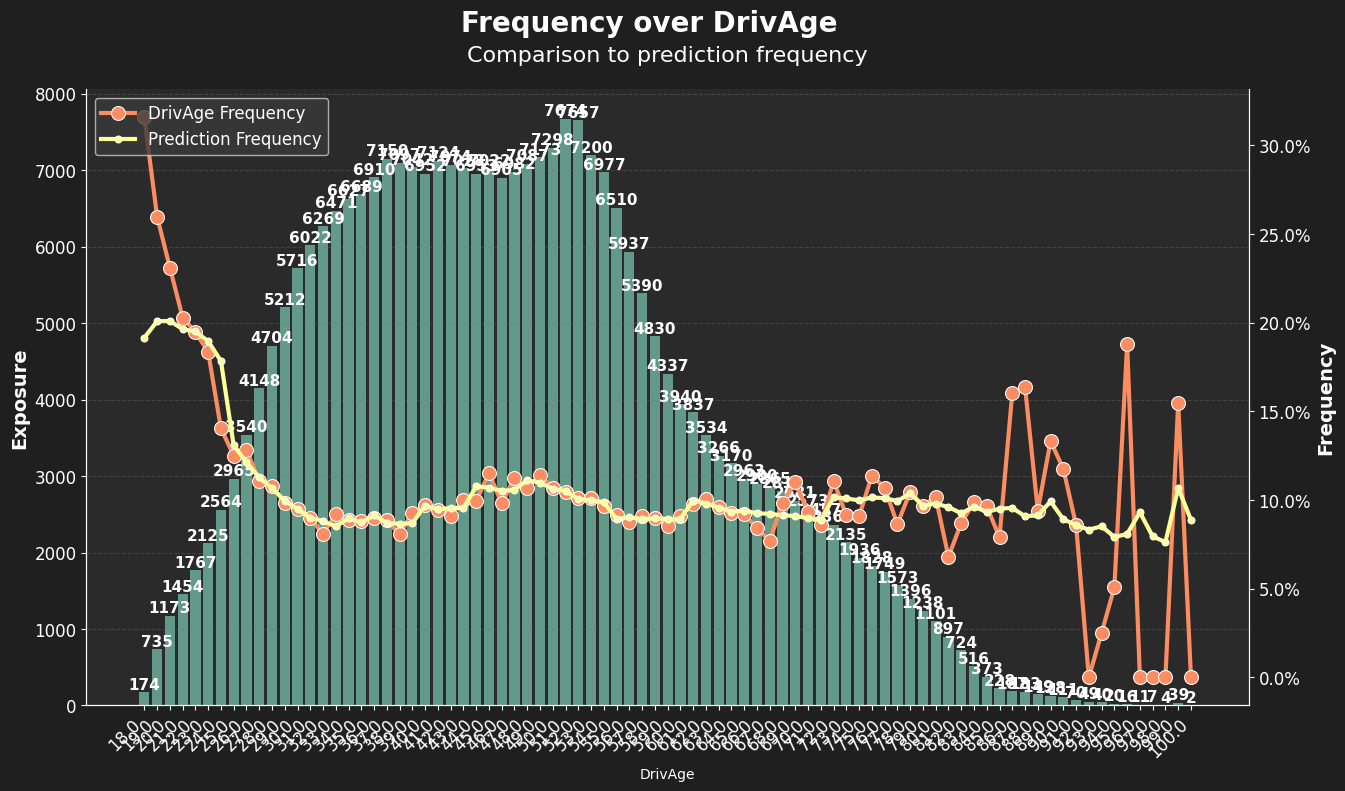

In [14]:
plot = freq_over_attribute_plot(X_train_pred_glm_tuned, attribute='DrivAge', compare_to='prediction')

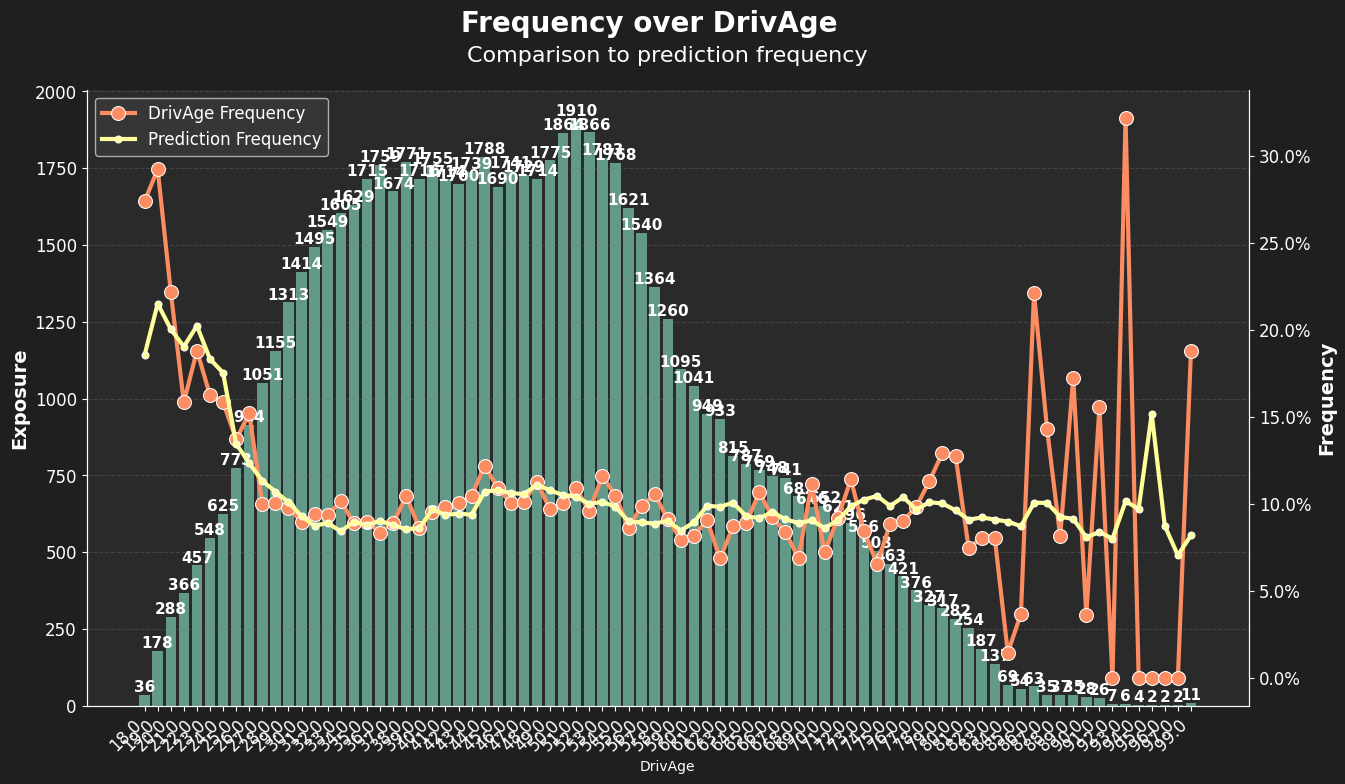

In [15]:
plot = freq_over_attribute_plot(X_test_pred_glm_tuned, attribute='DrivAge', compare_to='prediction')

## xgBoost

Problem `bias-variance trade-off` rozwiązuję przez `early_stopping`. Model przestaje się trenować dalej, jeżeli na zbiorach walidacyjnych w ramach walidacji krzyżowej metryka zaczyna się pogarszać.

### a. Korzystam z pipelinu z poprzedniego tuningu GLM

Z wykorzystaniem `hyperopt` przeszukuję przestrzeń parametrów modelu xgBoost (m.in. `learning_rate`, `max_depth`). Jako pipeline danych wykorzystuję pipeline, który wyszedł z trenowania poprzedniego modelu (GLM - PoissonRegressor). Rezultatem poszukiwań jest najlepszy zestaw parametrów, który następnie wykorzystuję do trenowania finalnego modelu na całym zbiorze `train`.

In [20]:
N_trials = 1
y_train, weights_train, y_freq_train, y_test, weights_test, y_freq_test = prepare_target_and_weights(train, test)
best = tune_xgboost_model(train, test, pipeline_features, n_trials=N_trials)

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the numbe

[0]	validation_0-poisson-nloglik:0.37994
[0]	validation_0-poisson-nloglik:0.38307
[0]	validation_0-poisson-nloglik:0.37923
[0]	validation_0-poisson-nloglik:0.37869
[0]	validation_0-poisson-nloglik:0.38218
[100]	validation_0-poisson-nloglik:0.36184
[100]	validation_0-poisson-nloglik:0.35898
[100]	validation_0-poisson-nloglik:0.36042
[100]	validation_0-poisson-nloglik:0.36084
[100]	validation_0-poisson-nloglik:0.35875
[200]	validation_0-poisson-nloglik:0.36136
[200]	validation_0-poisson-nloglik:0.35972
[200]	validation_0-poisson-nloglik:0.35857
[200]	validation_0-poisson-nloglik:0.35827
[200]	validation_0-poisson-nloglik:0.36061
[243]	validation_0-poisson-nloglik:0.35859
[257]	validation_0-poisson-nloglik:0.35818
[281]	validation_0-poisson-nloglik:0.36063
[300]	validation_0-poisson-nloglik:0.36103
[300]	validation_0-poisson-nloglik:0.35934
[367]	validation_0-poisson-nloglik:0.36093
[400]	validation_0-poisson-nloglik:0.35910
[449]	validation_0-poisson-nloglik:0.35906
100%|██████████| 1/1 

In [21]:
model_xgb_boost, (summary_xgboost, X_train_pred_xgboost, X_test_pred_xgboost) = (
    apply_best_params_and_train_xgboost_model(
        best, 
        train, 
        test, 
        pipeline_features, 
        f'../../models/xgboost_{N_trials}t_pipeline_best_from_glm_tuned'
    )
)


/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[0]	validation_0-poisson-nloglik:0.38312
[50]	validation_0-poisson-nloglik:0.36226
[100]	validation_0-poisson-nloglik:0.36111
[150]	validation_0-poisson-nloglik:0.36064
[200]	validation_0-poisson-nloglik:0.36041
[250]	validation_0-poisson-nloglik:0.36019
[300]	validation_0-poisson-nloglik:0.36005
[350]	validation_0-poisson-nloglik:0.35993
[400]	validation_0-poisson-nloglik:0.35976
[449]	validation_0-poisson-nloglik:0.35972
Model successfully saved to ../../models/xgboost_1t_pipeline_best_from_glm_tuned.pkl.joblib
Poisson Deviance Dummy Train: 62.330
Poisson Deviance Dummy Test: 63.116
Poisson Deviance Train: 56.448
Poisson Deviance Test: 58.102
Improvement in Deviance Train: 9.438%
Improvement in Deviance Test: 7.944%
Frequency Train Actual: 10.049%
Frequency Train Model: 10.047%
Frequency Test Actual: 10.109%
Frequency Test Model: 10.050%


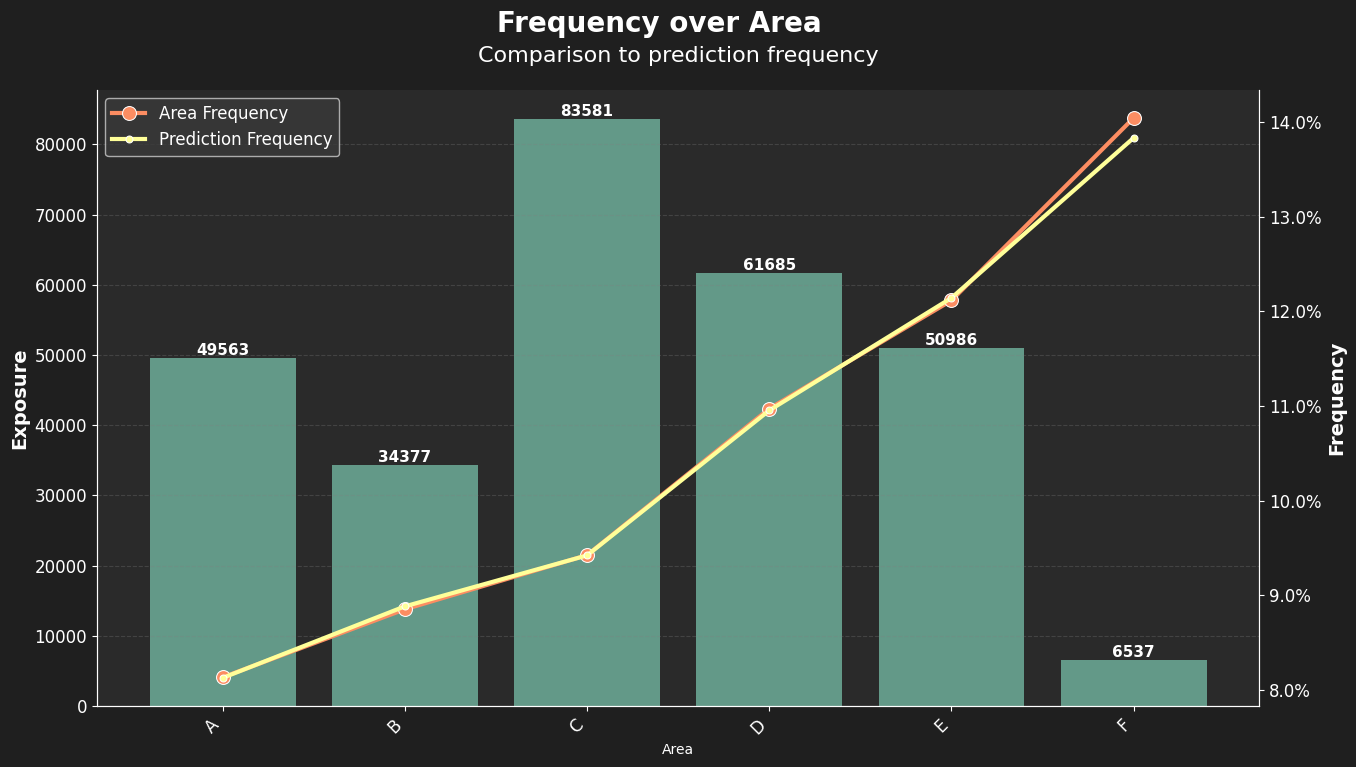

In [22]:
plot = freq_over_attribute_plot(X_train_pred_xgboost, attribute='Area', compare_to='prediction')

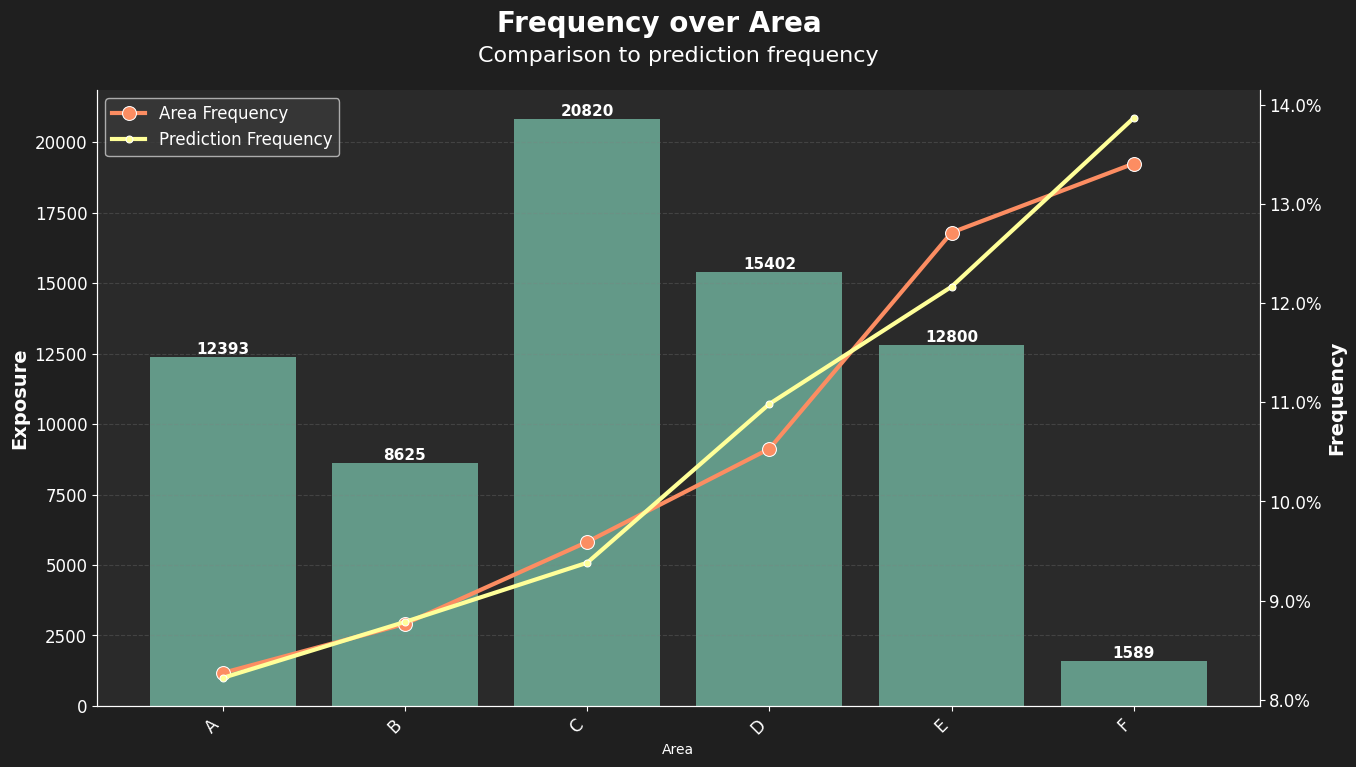

In [23]:
plot = freq_over_attribute_plot(X_test_pred_xgboost, attribute='Area', compare_to='prediction')

### b. Korzystam z prostego pipelinu (tylko imputowanie, skalowanie i dekodowanie zmiennych)

In [24]:
N_trials = 1
y_train, weights_train, y_freq_train, y_test, weights_test, y_freq_test = prepare_target_and_weights(train, test)
best = tune_xgboost_model(train, test, simple_pipeline_features, n_trials=N_trials)

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

[0]	validation_0-poisson-nloglik:0.37921
[0]	validation_0-poisson-nloglik:0.38270
[0]	validation_0-poisson-nloglik:0.38049
[0]	validation_0-poisson-nloglik:0.38360
[0]	validation_0-poisson-nloglik:0.37973
[66]	validation_0-poisson-nloglik:0.37063
[66]	validation_0-poisson-nloglik:0.36805
[100]	validation_0-poisson-nloglik:0.35807
[100]	validation_0-poisson-nloglik:0.36132
[100]	validation_0-poisson-nloglik:0.36140
[193]	validation_0-poisson-nloglik:0.36141
[200]	validation_0-poisson-nloglik:0.35754
[200]	validation_0-poisson-nloglik:0.36060
[245]	validation_0-poisson-nloglik:0.35752
[300]	validation_0-poisson-nloglik:0.36019
[400]	validation_0-poisson-nloglik:0.35999
[449]	validation_0-poisson-nloglik:0.35993
100%|██████████| 1/1 [01:03<00:00, 63.70s/trial, best loss: 0.5782149374848942]


In [26]:
model_xgb_boost, (summary_xgboost, X_train_pred_xgboost, X_test_pred_xgboost) = (
    apply_best_params_and_train_xgboost_model(
        best, 
        train, 
        test, 
        simple_pipeline_features, 
        f'../../models/xgboost_{N_trials}t_simple_pipeline'
    )
)

[0]	validation_0-poisson-nloglik:0.38364
[50]	validation_0-poisson-nloglik:0.36238
[100]	validation_0-poisson-nloglik:0.36110
[150]	validation_0-poisson-nloglik:0.36069
[200]	validation_0-poisson-nloglik:0.36040
[250]	validation_0-poisson-nloglik:0.36016
[300]	validation_0-poisson-nloglik:0.35999
[350]	validation_0-poisson-nloglik:0.35988
[400]	validation_0-poisson-nloglik:0.35972
[449]	validation_0-poisson-nloglik:0.35964
Model successfully saved to ../../models/xgboost_1t_simple_pipeline.pkl.joblib
Poisson Deviance Dummy Train: 62.330
Poisson Deviance Dummy Test: 63.116
Poisson Deviance Train: 56.487
Poisson Deviance Test: 58.087
Improvement in Deviance Train: 9.374%
Improvement in Deviance Test: 7.967%
Frequency Train Actual: 10.049%
Frequency Train Model: 10.047%
Frequency Test Actual: 10.109%
Frequency Test Model: 10.050%


### c. Hipertuning hipertuningu

In [35]:
n_trials_list = [1, 5, 10, 20, 30]
feature_pipelines = [simple_pipeline_features, pipeline_features]

for feature_pipeline in feature_pipelines:
    for N_trials in n_trials_list:
        y_train, weights_train, y_freq_train, y_test, weights_test, y_freq_test = prepare_target_and_weights(train, test)
        best = tune_xgboost_model(train, test, feature_pipeline, n_trials=N_trials)
        model_xgb_boost, (summary_xgboost, X_train_pred_xgboost, X_test_pred_xgboost) = (
        apply_best_params_and_train_xgboost_model(
            best, 
            train, 
            test, 
            feature_pipeline, 
            f'../../models/xgboost_{N_trials}t_{"simple_pipeline" if feature_pipeline == simple_pipeline_features else "pipeline"}'
            )
        )
    

../../models/xgboost_1t_simple_pipeline
../../models/xgboost_5t_simple_pipeline
../../models/xgboost_10t_simple_pipeline
../../models/xgboost_20t_simple_pipeline
../../models/xgboost_30t_simple_pipeline
../../models/xgboost_1t_pipeline_best_from_glm_tuned
../../models/xgboost_5t_pipeline_best_from_glm_tuned
../../models/xgboost_10t_pipeline_best_from_glm_tuned
../../models/xgboost_20t_pipeline_best_from_glm_tuned
../../models/xgboost_30t_pipeline_best_from_glm_tuned
